Implementation and comparision of LSTM(Long Short Term Memory) and ARIMA(Autoregressive integrated moving average) Neural Networks for the application of Stock Price Prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from example_functions import fetch_store, preprocessing_data, generate_sequence

We shall follow the following steps to achieve the goal:
1. Fetch and store the data(Stock Prices for the past few time intervals).
2. Split the data for Training and Testing.
3. Processing of data to meet the input criterion of the Neural Network Algorithms.
4. Pass the data through LSTM and ARIMA and train the networks.
5. Start Predicting the upcoming Stock Prices for the next few time intervals using the 2 models.
6. Compare the results of the 2 models and conclude.


The following code has all the required functions used by the main function

(6399, 100)
(6399, 100, 1)
(3399, 100)
(3399, 100, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
100/100 [==============================] - 35s 266ms/step - loss: 0.0069 - val_loss: 0.0013


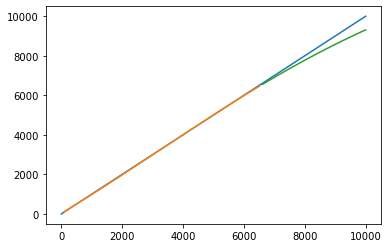

In [2]:
## Configuration Parameters

# Used to divide the data into training set and test set i.e.,
# Percentage of Training data in the whole set of data
percentage_train_data = 0.65

# Dependence Interval specifies the number of previous intervals used
# to predict the next interva's output
dependence_interval = 100


## Step - 1
# Fetches and Stores data
%run -i additional_functions.py
data = fetch_store ()


## Step - 2
# Preprocesses the data for LSTM and Splits the data among training and testing 
%run -i additional_functions.py
scaler, processed_data, processed_train_data, processed_test_data = preprocessing_data (data, percentage_train_data)


## Step - 3
# Creating Training and Test Sequence and the corresponding otput sequence from the data
%run -i additional_functions.py
train_sequence, expected_train_output_seq = generate_sequence(processed_train_data, dependence_interval)
test_sequence, expected_test_output_seq = generate_sequence(processed_test_data, dependence_interval)


## Step - 4
# Call LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_sequence.shape[1],train_sequence.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

model.fit(train_sequence,expected_train_output_seq,validation_data=(test_sequence,expected_test_output_seq),epochs=1,batch_size=64,verbose=1)

### Lets Do the prediction and check performance metrics
train_predict = model.predict(train_sequence)
test_predict = model.predict(test_sequence)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(expected_train_output_seq, train_predict))

### Test Data RMSE
math.sqrt(mean_squared_error(expected_test_output_seq,test_predict))

### Plotting 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(processed_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[dependence_interval:len(train_predict)+dependence_interval, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(processed_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(dependence_interval*2)+1:len(processed_data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(processed_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [3]:
# prediction_input = processed_data[-1*dependence_interval:]

# prediction_intervals = 10
# for iter in range(prediction_intervals):
#     print(iter)
#     lstm_input_data = np.array(prediction_input[-1*dependence_interval:])
#     lstm_input_data = lstm_input_data.reshape(1,-1)
#     lstm_input_data = lstm_input_data.reshape((1, dependence_interval, 1))
    
#     next_iterval_prediction = scaler.inverse_transform(model.predict(lstm_input_data, verbose=0))
#     print(next_iterval_prediction)
#     prediction_input.extend(next_iterval_prediction.tolist())
    

# print(prediction_input)
temp_input=list(processed_data[-1*dependence_interval-1:])
print(len(temp_input))
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
#         print(i)
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0])
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
        

101
